## Estimating Travel Time


The objective of this document is proposing a prediction model for estimating the travel time of two
specified locations at a given departure time. The main idea here is predicting the velocity of the trip. Given the distance between starting and ending point of the trip, it is possible to easily compute the Travel Time. 
According to the given data, different features including the time of the day, day of the week, month, travel distance, and distance to the center of the city (New York) are used.
Different prediction models (Linear, GLM and Deep Neural Network) are compared, and the GLM is used for genrating the final results.

## Preparation
Import required libraries

In [136]:
import numpy as np
import pandas as pd
from geopy.distance import vincenty
from datetime import datetime
from datetime import timedelta
from datetime import time

import statsmodels.api as sm
 


from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns



from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization


%matplotlib inline

##  Reading data

In [169]:
df_train = pd.read_csv('train.csv',index_col= 'row_id')
df_test  = pd.read_csv('test.csv',index_col= 'row_id')
df_train.head()

/Users/z002df6/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration
row_id,,,,,,
0,-74.009087,40.713818,-74.004326,40.719986,1420950819,112
1,-73.971176,40.762428,-74.004181,40.742653,1420950819,1159
2,-73.994957,40.745079,-73.999939,40.734650,1421377541,281
3,-73.991127,40.750080,-73.988609,40.734890,1421377542,636
4,-73.945511,40.773724,-73.987434,40.755707,1422173586,705


## Feature engineering

It is clear that the travel time of trip depends on the starting and ending point. In other words, the most uncertain component in the prediction of travel time is the velocity of the trip. Given the velocity and the distance, it is easy to compute the duration of the travel. 

Also, I observed all travels in both train and test dataset are happening around New York City. Therefore, the main component in determining the velocity of is the city traffic. We know that traffic is a time-dependent phenomenon which depends on the time of the day, the day of the week, and month of the year. In addition, the traffic is usually heavier in Manhattan (downtown of the city) in comparing to the other point of the city. Therefore, if the starting or ending point of the travel is close to the Manhattan we expect higher traffic comparing to the other neighborhoods. In visualization section, I provide enough evidence from the data set to support the aforementioned claims.   

According to this observation the following features are computted by using the raw data and added to the dataframe.

* Distance between starting and ending computted by vincenty formula
* The time of the day of travel (in sec far from the midnight) 
* The day of the week (Monday, Tuesday, etc). For this categorical data, six dummy variables are added to datafram
* The month of the travel to capture seasnolity effect.
* The sequare of distance
* The velocity is used as the predication variable.


In [156]:
def distance(row):
    source = (row['start_lat'], row['start_lng'])
    dest = ( row['end_lat'], row['end_lng'])
    return vincenty(source,dest).miles


Manhattan = (40.7831, -73.9712)
def pickup_to_MH(row):
    '''find the distance between pick up point and Manhattan center'''
    source = (row['start_lat'], row['start_lng'])
    return vincenty(source,Manhattan).miles

def dropoff_to_MH(row):
    '''find the distance between dropoff point and Manhattan center'''
    dest = ( row['end_lat'], row['end_lng'])
    return vincenty(dest,Manhattan).miles

def day_of_week(ep):
    return datetime.fromtimestamp(ep).strftime("%A")


def month(ep):
    return datetime.fromtimestamp(ep).month

def time_of_day(ep):
    ref = datetime(2015, 1, 1, 0, 0, 0)
    sec = (datetime.fromtimestamp(ep)- ref).seconds
    return min(sec, 86400- sec)
    
def year(ep):
    return datetime.fromtimestamp(ep).year

def add_features(df_train_s):
    
    # Add day of the week and the dummy variable
    DD  = df_train_s['start_timestamp'].map(day_of_week)
    df_train_s['day'] = DD
    
    DD  = pd.get_dummies( DD,prefix='day', drop_first=True)
    df_train_s = pd.concat([df_train_s, DD],axis =1 )

    # Month, time of the dat, df_train_s
    df_train_s['month']  = df_train_s['start_timestamp'].map(month)
    df_train_s['time_of_day']  = df_train_s['start_timestamp'].map(time_of_day)
 
    # distance between start and end of the trip
    df_train_s['distance']   = df_train_s.apply(lambda x :distance(x), axis=1 )
    df_train_s['distance2'] = df_train_s['distance']**2

    # distance between start, end, and center of Manhatan 
    df_train_s['pickup_MH']  = df_train_s.apply(pickup_to_MH, axis=1 )
    df_train_s['dropoff_MH'] = df_train_s.apply(dropoff_to_MH, axis=1 )
    return df_train_s

Now, we can easily add all of the above features to both traing and test data set. Due to time limtation and calculation power I only used 10% of the traing data.

In [24]:
np.random.seed(42)
df_train_s = df_train.sample(frac=0.01, replace=False)
df_train_s = add_features(df_train_s)
df_train_s['velocity'] = np.array(df_train_s['distance']/(df_train_s['duration']/3600))


In [25]:
df_train_s.head()

,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,day,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,month,time_of_day,distance,pickup_MH,dropoff_MH,velocity
row_id,,,,,,,,,,,,,,,,,,,
9780992,-73.989853,40.755650,-74.183144,40.687981,1443634595,1415,Wednesday,0,0,0,0,0,1,9,38195,11.170204,2.131971,12.916332,28.418893
2996891,-73.958855,40.774952,-73.968918,40.763908,1425321185,646,Monday,1,0,0,0,0,0,3,37985,0.927061,0.857563,1.329705,5.166283
937249,-73.987465,40.749176,-74.005402,40.727180,1420942464,762,Saturday,0,1,0,0,0,0,1,20736,1.786044,2.491536,4.255566,8.438002
4483011,-73.965347,40.774792,-73.964058,40.770973,1428517239,164,Wednesday,0,0,0,0,0,1,4,40839,0.272059,0.650309,0.916834,5.972035
1285264,-74.006622,40.744011,-74.008812,40.704350,1423735890,715,Thursday,0,0,0,1,0,0,2,7890,2.739118,3.275508,5.781371,13.791361


In [170]:
# adding the feature to test set.
df_test = add_features(df_test)

## Removing Outlires
The following functions are used to compute these features. Considering the speed limit and the fact the usual trafic in New York, it is reseanable to assume that always the speed show not exceed 90 mph. Therefore, I remove the points with more than this number as the outlires. Also, I removed the data with less than .5 mph. Specificlly, there exists many samples with zero distance between starting and ending point which might happen becouse GPS problem.

In [41]:
df_train_s = df_train_s[df_train_s['velocity']<90]
df_train_s = df_train_s[df_train_s['velocity']>.5]

## Data Visulazation

First we look at the starting and ending point of the trips which happens in New York.




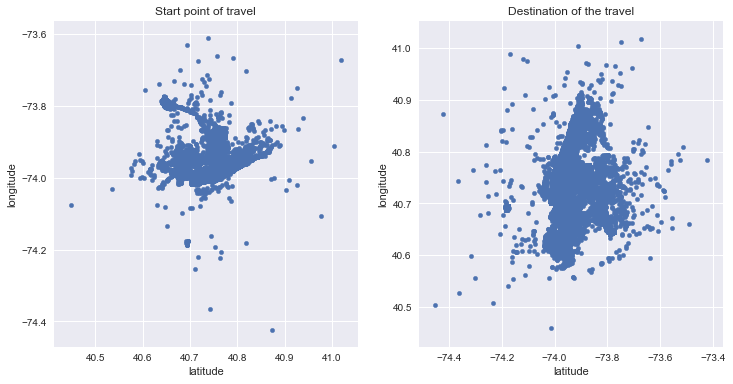

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax = df_train_s.plot.scatter( 'start_lat','start_lng',
                             ax = axes[0],
                             title='Start point of travel')
ax.set(xlabel="latitude", ylabel='longitude')
ax = df_train_s.plot.scatter('end_lng','end_lat',
                        ax = axes[1],
                        title='Destination of the travel')
ax.set(xlabel="latitude", ylabel='longitude')
plt.show()

 Here are some statitcs about the volacity, distance of each trip and its duration. Also, we looked at the density function of the volacity. A log-normal or Gamma distribution are approprate candiatdes for this distribution.

In [42]:
df_train_s[['distance', 'duration','velocity']].describe()

,distance,duration,velocity
count,128036.000000,128036.000000,128036.000000
mean,2.169607,844.237621,9.091566
std,2.427614,668.033514,4.828527
min,0.000420,1.000000,0.500455
25%,0.791981,404.000000,5.766028
50%,1.342186,669.000000,8.094952
75%,2.455935,1081.000000,11.294384
max,29.962159,25693.000000,58.945106


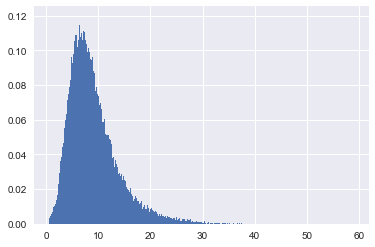

In [43]:
df_train_s['velocity'].hist(bins=1000,normed=True)

### Corrolation matrix

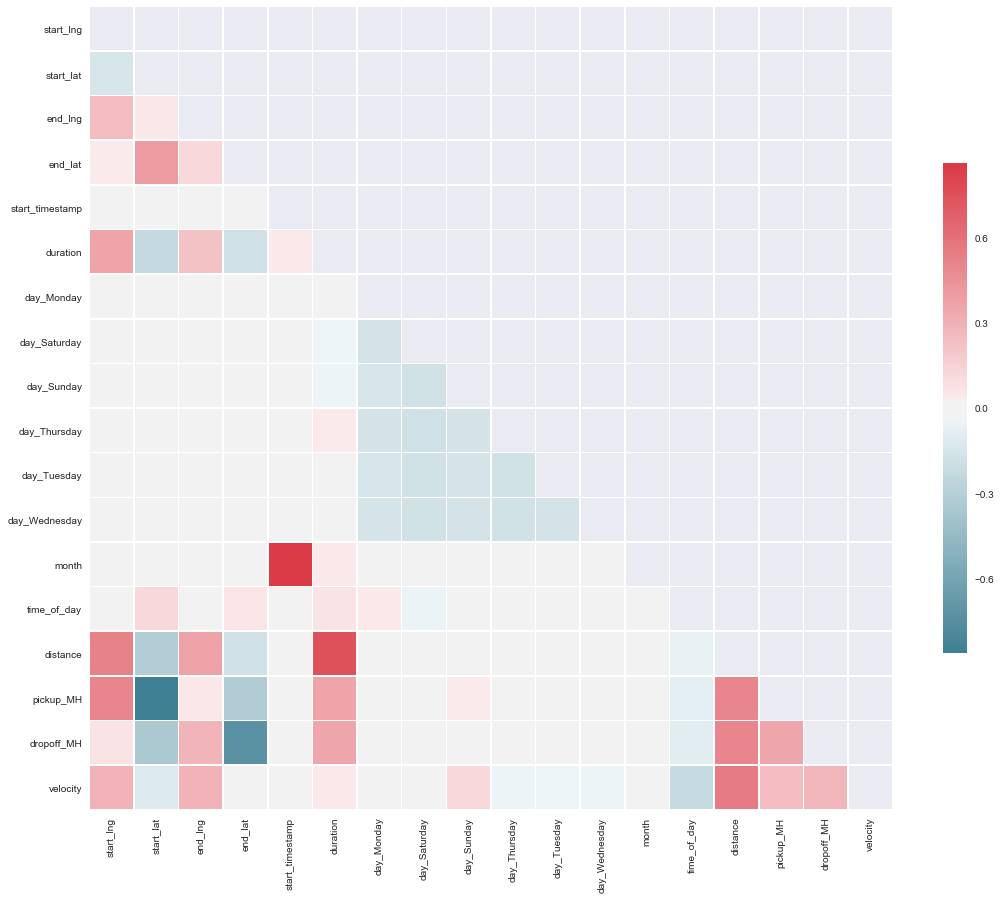

In [44]:
corr = df_train_s.corr()

# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

plt.show()

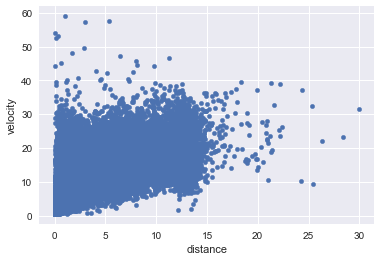

In [53]:
df_train_s.plot.scatter( 'distance','velocity')

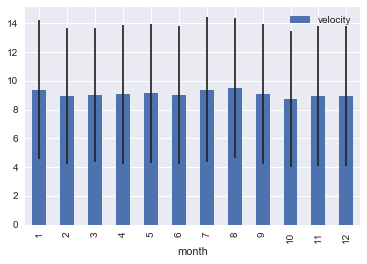

In [48]:
### Seanility and time Effect on Velocity
gr= df_train_s[['velocity','month']].groupby(by='month')
gr.mean().plot.bar(yerr=gr.std())

## Data preprocessing

Let's split our data to train and test set in fraction of $\frac{4}{1}$ to facilate comparing the results. 
This test set is differenet from the given test set.

In [105]:
cl = list(set(df_train_s.keys())-{'velocity','duration','day'})
X  = np.array(df_train_s[cl])
X1 = np.insert(X, 0, 1, axis=1)
y = np.array(df_train_s['velocity'])


X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

dist_train = X_train[:,1]
dist_test  = X_test[:,1]


In [106]:
list(enumerate(cl))
dist_train.mean()

2.1668461824987508

## Linear Model 

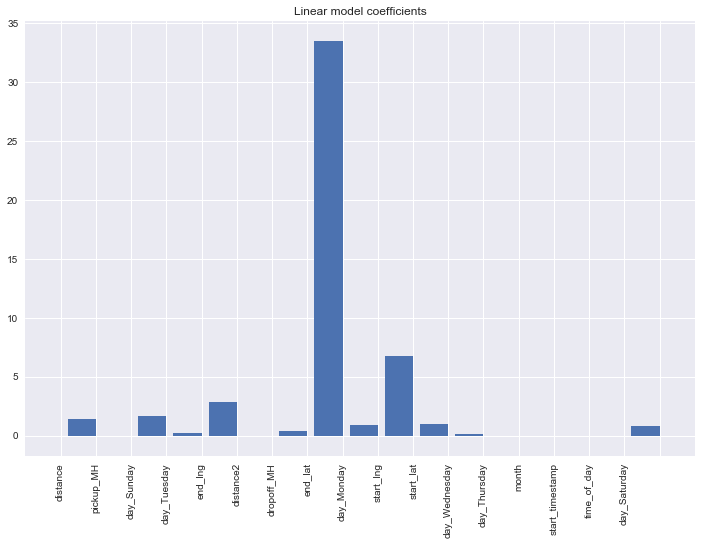

In [204]:
model_sk = LinearRegression()
model_sk.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plt.bar(np.arange(model_sk.coef_.shape[0]) - 0.4, model_sk.coef_)
plt.xticks(np.arange(model_sk.coef_.shape[0]), cl, rotation='vertical')
plt.xlim([-1, model_sk.coef_.shape[0]])
plt.title("Linear model coefficients")
plt.show()


The folling chart also provide better understading. Excepet X12 (dummy for sunday) all the other variables are significant; the p-value is zero and null-hypothesis is rejected.

In [205]:
linear_model = sm.OLS(y_train, X_train)
linear_results = linear_model.fit()
print(linear_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     3980.
Date:                Thu, 28 Dec 2017   Prob (F-statistic):               0.00
Time:                        08:56:07   Log-Likelihood:            -2.8052e+05
No. Observations:              102428   AIC:                         5.611e+05
Df Residuals:                  102410   BIC:                         5.612e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -685.1248     83.582     -8.197      0.0

## Generalized Linear Model
I tried GLM with gamma fammaly. 

In [206]:
gamma_model = sm.GLM( y_train, X_train,family=sm.families.Gamma())
gamma_results = gamma_model.fit()
print(gamma_results.summary())

/Users/z002df6/anaconda/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:244: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               102428
Model:                            GLM   Df Residuals:                   102414
Model Family:                   Gamma   Df Model:                           13
Link Function:          inverse_power   Scale:                   0.19442760013
Method:                          IRLS   Log-Likelihood:            -2.8026e+05
Date:                Thu, 28 Dec 2017   Deviance:                       21788.
Time:                        08:56:25   Pearson chi2:                 1.99e+04
No. Iterations:                   100                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0060      0.345     17.384      0.000       5.329       6.683
x1            -0.0146   9.13e-05   -159.591      0.0

## Deep Neural Network (DNN)

Here, I am useing a DNN as a prediction model. I am using the Keras package to train the network. Network includes  3 layers. Also, between each two layer a dropout layer is add. RELU and softmax are used as the activation functions. Here, I define the model.  

I normilized the data the input data to imporve the performance. 

In [195]:
DNN_model = Sequential()
DNN_model.add(Dense(100,input_dim=X_train.shape[1],init='uniform',activation='relu'))
DNN_model.add(Dropout(0.5))
DNN_model.add(Dense(50,init='uniform',activation='softmax'))
DNN_model.add(Dropout(0.5))
DNN_model.add(Dense(100,init='uniform',activation='relu'))
DNN_model.add(Dropout(0.5))
DNN_model.add(Dense(1,init='uniform',activation='relu'))

DNN_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 100)               1900      
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               5100      
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 101       
Total para

/Users/z002df6/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, input_dim=18, activation="relu", kernel_initializer="uniform")`
  
/Users/z002df6/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="softmax", kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/Users/z002df6/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", kernel_initializer="uniform")`
  
/Users/z002df6/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  


### Fitting the DNN

In [196]:
mn = X1.mean(axis=0)
#model.compile(loss='mean_absolute_error',optimizer='adam',metrics='[accuracy]')
DNN_model.compile(loss='mean_absolute_error',optimizer='adam')
history = DNN_model.fit(X_train/mn,y_train,  
                    validation_data=(X_test/mn, y_test),
                    epochs =100,
                    batch_size=100,
                    verbose=2)



Train on 102428 samples, validate on 25608 samples
Epoch 1/100
2s - loss: 3.8939 - val_loss: 2.8545
Epoch 2/100
2s - loss: 3.0103 - val_loss: 2.8045
Epoch 3/100
2s - loss: 2.9702 - val_loss: 2.7933
Epoch 4/100
2s - loss: 2.9282 - val_loss: 2.7548
Epoch 5/100
2s - loss: 2.9222 - val_loss: 2.7306
Epoch 6/100
2s - loss: 2.9013 - val_loss: 2.7235
Epoch 7/100
2s - loss: 2.8852 - val_loss: 2.7172
Epoch 8/100
2s - loss: 2.8784 - val_loss: 2.7125
Epoch 9/100
2s - loss: 2.8572 - val_loss: 2.6998
Epoch 10/100
2s - loss: 2.8461 - val_loss: 2.6974
Epoch 11/100
2s - loss: 2.8372 - val_loss: 2.7010
Epoch 12/100
2s - loss: 2.8295 - val_loss: 2.6925
Epoch 13/100
2s - loss: 2.8248 - val_loss: 2.6924
Epoch 14/100
2s - loss: 2.8133 - val_loss: 2.6827
Epoch 15/100
2s - loss: 2.8123 - val_loss: 2.6869
Epoch 16/100
2s - loss: 2.7984 - val_loss: 2.6885
Epoch 17/100
2s - loss: 2.7926 - val_loss: 2.6851
Epoch 18/100
2s - loss: 2.7892 - val_loss: 2.6849
Epoch 19/100
2s - loss: 2.7831 - val_loss: 2.6757
Epoch 20

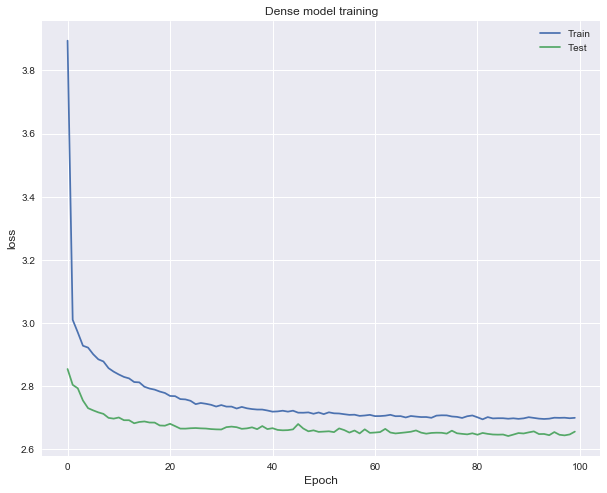

In [197]:
plt.figure(figsize=(10, 8))
plt.title("Dense model training", fontsize=12)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Test")
plt.grid("on")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend(loc="upper right")

## Evalution

In this part, I compare the propsed models and choose the best one. I compare the results based on mean absolute
error of predicted versus actual durations, and also mean absolute percentage error which is the percantge of the error. Note that here  we compare based on duration as asked in the question and not the velocity. 


In [207]:
preds_test, preds_train = {}, {}

#Linear Model
preds_test['linear']  = linear_results.predict(X_test)
preds_train['linear'] = linear_results.predict(X_train)

#GLM (Gamma Model)

preds_test['GLM']  = gamma_results.predict(X_test)
preds_train['GLM'] = gamma_results.predict(X_train)

#Deep Learning
preds_test['DL']  = np.squeeze(DNN_model.predict(X_test/mn))
preds_train['DL'] = np.squeeze(DNN_model.predict(X_train/mn))




The functions are used for evalution

In [84]:
def mean_absolute_error(dist,y_true, y_pred ): 
    """
    Args: 
        dist(ndarray)   : distance between pick up and drop off 
        y_true(ndarray) : true velocity
        y_pred(ndarray) : the prediction value of velocity

    """
    err = np.abs(dist/y_true - dist/y_pred)
    err = err[np.isfinite(err)]
    return np.mean(err) *3600


def mean_absolute_percentage_error(dist,y_true, y_pred ): 
    """
    Args: 
        dist(ndarray)   : distance between pick up and drop off 
        y_true(ndarray) : true velocity
        y_pred(ndarray) : the prediction value of velocity

    """
    err = np.abs(y_true/y_pred - 1)
    err = err[np.isfinite(err)]
    return np.mean(err)*100


def evalute(dist,y_true,prediction):
    MAE, MAPE= {}, {}
    for kys, y_pred in prediction.items():
        MAE[kys]   = mean_absolute_error(dist,y_true, y_pred )
        MAPE[kys]  = mean_absolute_percentage_error(dist,y_true, y_pred )
        
        
    return MAE, MAPE

In [209]:
MAE_train, MAPE_train = evalute(dist_train,y_train, preds_train)
MAE_test, MAPE_test = evalute(dist_test,y_test, preds_test)


pd.DataFrame([MAE_test,MAE_train, MAPE_test, MAPE_train], 
             index=  ['MAE_test', 'MAE_train', 'MAPE_test', 'MAPE_train'] ).transpose()

,MAE_test,MAE_train,MAPE_test,MAPE_train
DL,7.360206,7.330754,33.989024,33.661978
GLM,6.786721,7.246643,32.516880,32.406202
linear,7.299544,7.264867,31.866012,31.679155


In [201]:
dist_train.mean()

2.1668461824987508

## Generate Prediction for Test Set

By comparing the three models (linear, GLM, DNN), I choose GLM for generating the predication for the given test set. 

In [212]:
XX  = np.array(df_test[cl])
XX = np.insert(XX, 0, 1, axis=1)

dist_x = XX[:,1]
#DNN_TD = dist_x/np.squeeze(DNN_model.predict(XX/mn))*3600
GLM_TD = dist_x/gamma_results.predict(XX)*3600
df_ans= pd.DataFrame(GLM_TD, columns =['duration'])


df_ans.index.name = 'row_id'
df_ans.to_csv('answer.csv')
df_ans= pd.DataFrame(TD, columns =['duration'])

##  Extention and Further Idea
Here, we only use the vincenty, but by conteccting to google API and fidning the real distance between start and end point the preditor defenitlly can be improved. Also, here I only used 10% of data points becouse of the limitation on runnig the DNN. By using GPU or running over the cloud we can use all the samples. 



